In [1]:
import datetime as dt
import os, sys
import netCDF4 as nc
import matplotlib as mpl
import numpy as np
import numpy.ma as ma
from scipy.spatial import distance
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import cm
import matplotlib.colors as mpl_colors
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from dateutil.relativedelta import relativedelta



from salishsea_tools import geo_tools, viz_tools

get_ipython().magic('matplotlib inline')

In [2]:

filesdir = "/ocean/gsgarbi/selected_days/"

dirs = os.listdir(filesdir)



Iona = (-123.30898284912109, 49.187351226806641)
S15 = (-123.3114, 49.130412)
S16 = (-123.317415, 49.1214)
xl=(-126.2,-122.2)
yl=(47.1,51)

In [3]:
def plot(points, title = 'title', picname = "noname", b=0):
    
    
    cmap = plt.get_cmap('nipy_spectral')
    cmap.set_bad('burlywood')


    plt.clf()
    start = dt.datetime.now()
    print ("start: ", start)

    mesh = nc.Dataset("/ocean/gsgarbi/mesh_mask_downbyone2.nc")
    tmask=np.copy(mesh.variables['tmask'])
    mesh.close()
    fb=nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/bathy_downonegrid2.nc')
    nav_lon=np.copy(fb.variables['nav_lon'])
    nav_lat=np.copy(fb.variables['nav_lat'])
    fb.close()
    
    lonlim=[np.min(nav_lon),np.max(nav_lon)]
    latlim=[np.min(nav_lat),np.max(nav_lat)]


    griddata=0.0*tmask[0,0,:,:]
    griddata.shape


    griddata, iedges, jedges = np.histogram2d(points[:,1],points[:,2],
                                                  bins=[100,200],
                                                  range=[lonlim,latlim])


    Jedges,Iedges=np.meshgrid(jedges,iedges)
    

    fig, axs = plt.subplots(1,1,figsize=(5,4))
    mesh0 = axs.pcolormesh(Iedges,Jedges,griddata,cmap=cmap)
    mesh0.set_clim(vmin = 0)
    axs.set_xlim(xl)
    axs.set_ylim(yl)
    pos=axs.get_position()
    pos2=(pos.bounds[0],pos.bounds[1],pos.bounds[2]-.05,pos.bounds[3])
    axs.set_position(pos2)
    axs2 = plt.axes(pos2)
    viz_tools.set_aspect(axs,coords='map')
    mesh1=axs2.pcolormesh(nav_lon,nav_lat,np.ma.masked_where(tmask[0,0,:,:]==1,tmask[0,0,:,:]),cmap='YlOrRd')
    axs2.set_xlim(xl)
    axs2.set_ylim(yl)
    axs2.patch.set_alpha(0)
    viz_tools.set_aspect(axs2,coords='map')
    axsCB=plt.axes((pos2[0]+pos2[3],pos2[1],.02,pos2[3]))
    cbar = fig.colorbar(mesh0,cax=axsCB)
    cbar.set_label ("Counts")
    

    
    el = Ellipse((2, -1), 0.5, 0.5)

    axs2.annotate(
            "  IONA",
            xy=(Iona[0], Iona[1]), xytext=(50, 10),
            textcoords='offset points', ha='left', va='bottom', color = 'white',
            arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                                      fc=(1,1,1), ec=(1., .5, .5),
                                      patchA=None,
                                      patchB=el,
                                      relpos=(0.2, 0.8),
                                      connectionstyle="arc3,rad=-0.1"))

    fb=nc.Dataset('/ocean/gsgarbi/revised_notebooks/ncfiles/bathymetry_201702.nc')

    B = np.copy(fb.variables ['Bathymetry'])
    LON = np.copy(fb.variables ['nav_lon'])
    LAT = np.copy(fb.variables ['nav_lat'])
    fb.close()
   
    axs2.contour(LON,LAT,B,levels=[50,], colors = ['w',], linewidths = [0.8,])
        
    xc = np.mean(points[:,1])
    yc = np.mean(points[:,2])
    xs = np.std(points[:,1])
    ys = np.std(points[:,2])
    
    axs2.plot(xc,yc,"kx", ms = 10)
    
    axs.set_title( title + "\n Total of trajectories: {} \n".format( 
        int(np.sum(griddata)) ) + "STD: ({}, {})".format(round(xs,2), 
                                                         round(ys,2)) +
                 " Centroid: ({}, {})".format (round(xc, 2), round(yc, 2))
                                                        )
    
    
    plt.savefig(picname, transparent = True)
    


In [4]:
end_date = dt.date(2016, 7,1)
nday = 100


def lessthan (filesdir, end_date = dt.date(2016, 7,1), nday = 100, ppd = 72):
    
    
    last_month = end_date.month
    start_date = end_date - relativedelta(days = nday)
    first_month = start_date.month
    
    dirs = os.listdir(filesdir)
    
    #choose and format months
    months = range(first_month, last_month+1)
    fmonths = []
    for m in months:
        
        if len(str(m)) == 1:
            m = "0"+str(m)
            fmonths.append(m)
        else:
            fmonths.append(str(m))
    
    #restricted eligible files in dirs based on nday and enddate so it won't take long
    dirs = sorted ([i for i in dirs if i[4:6] in fmonths])
    
    pts = []
    

    
        
    for day in range (nday):

        loop_date = start_date + dt.timedelta(days = day)

        loop_month = loop_date.month
        
        loop_day = loop_date.day
        days_left = (end_date - loop_date).days


        #format month
        if len (str(loop_month)) == 2:
            fl_m = str(loop_month)
        else:
            fl_m = "0" + str(loop_month)

        print (loop_date, fl_m, days_left)
        

        #select the file we want
        for file in dirs:
            
            
            if "{}d.npy".format(days_left) == file[18:] and fl_m == file[4:6]:

                print ('check')
                array = np.load(open(filesdir + file, 'rb'))
                
                
                #select the 72 trajectories from the day in the current month that we need
                array = array [ppd*(loop_day-1):ppd*(loop_day)]

                pts.append(array)
                
                print (len (np.array([i for sublist in pts for i in sublist])))
                
                
    #flatten the list
    pts = np.array([i for sublist in pts for i in sublist])

    
    return pts

2016-08-23 08 100
check
72
2016-08-24 08 99
check
144
2016-08-25 08 98
check
216
2016-08-26 08 97
check
288
2016-08-27 08 96
check
360
2016-08-28 08 95
check
432
2016-08-29 08 94
check
504
2016-08-30 08 93
check
576
2016-08-31 08 92
check
576
2016-09-01 09 91
check
648
2016-09-02 09 90
check
720
2016-09-03 09 89
check
792
2016-09-04 09 88
check
864
2016-09-05 09 87
check
936
2016-09-06 09 86
check
1008
2016-09-07 09 85
check
1080
2016-09-08 09 84
check
1152
2016-09-09 09 83
check
1224
2016-09-10 09 82
check
1296
2016-09-11 09 81
check
1368
2016-09-12 09 80
check
1440
2016-09-13 09 79
check
1512
2016-09-14 09 78
check
1584
2016-09-15 09 77
check
1656
2016-09-16 09 76
check
1728
2016-09-17 09 75
check
1800
2016-09-18 09 74
check
1872
2016-09-19 09 73
check
1944
2016-09-20 09 72
check
2016
2016-09-21 09 71
check
2088
2016-09-22 09 70
check
2160
2016-09-23 09 69
check
2232
2016-09-24 09 68
check
2304
2016-09-25 09 67
check
2376
2016-09-26 09 66
check
2448
2016-09-27 09 65
check
2520
2016-0

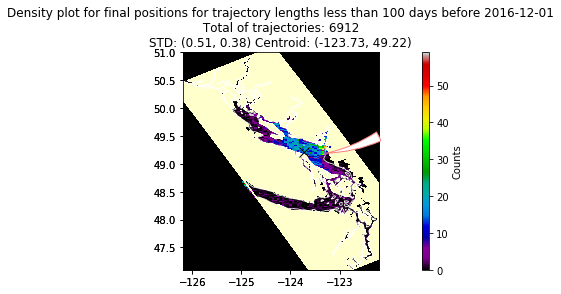

In [7]:
end_date = dt.date(2016, 12,1)
nday = 100

points = lessthan(filesdir, nday = nday, end_date = end_date)


title = (
    "Density plot for final positions for trajectory lengths less than {} days before {}".format(nday, end_date)
)

picname = "/ocean/gsgarbi/MEOPAR/private-docs/reports/IonaProject/ionafigs/{}_{}d_lessthan".format(end_date, nday)

plot (points, title, picname)


plt.show()

2016-10-12 10 50
check
72
2016-10-13 10 49
check
144
2016-10-14 10 48
check
216
2016-10-15 10 47
check
288
2016-10-16 10 46
check
360
2016-10-17 10 45
check
432
2016-10-18 10 44
check
504
2016-10-19 10 43
check
576
2016-10-20 10 42
check
648
2016-10-21 10 41
check
720
2016-10-22 10 40
check
792
2016-10-23 10 39
check
864
2016-10-24 10 38
check
936
2016-10-25 10 37
check
1008
2016-10-26 10 36
check
1080
2016-10-27 10 35
check
1152
2016-10-28 10 34
check
1224
2016-10-29 10 33
check
1296
2016-10-30 10 32
check
1368
2016-10-31 10 31
check
1368
2016-11-01 11 30
check
1440
2016-11-02 11 29
check
1512
2016-11-03 11 28
check
1584
2016-11-04 11 27
check
1656
2016-11-05 11 26
check
1728
2016-11-06 11 25
check
1800
2016-11-07 11 24
check
1872
2016-11-08 11 23
check
1944
2016-11-09 11 22
check
2016
2016-11-10 11 21
check
2088
2016-11-11 11 20
check
2160
2016-11-12 11 19
check
2232
2016-11-13 11 18
check
2304
2016-11-14 11 17
check
2376
2016-11-15 11 16
check
2448
2016-11-16 11 15
check
2520
2016-1

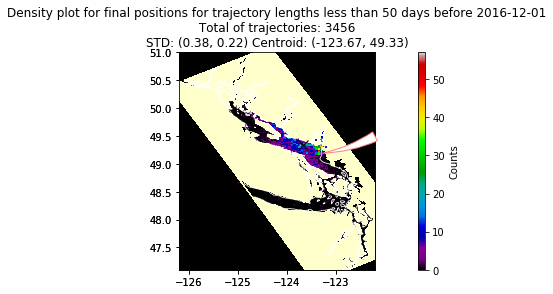

In [8]:
end_date = dt.date(2016, 12,1)
nday = 50

points = lessthan(filesdir, nday = nday, end_date = end_date)


title = (
    "Density plot for final positions for trajectory lengths less than {} days before {}".format(nday, end_date)
)

picname = "/ocean/gsgarbi/MEOPAR/private-docs/reports/IonaProject/ionafigs/{}_{}d_lessthan".format(end_date, nday)

plot (points, title, picname)


plt.show()

2016-11-28 11 3
check
72
2016-11-29 11 2
check
144
2016-11-30 11 1
check
144
start:  2017-06-30 14:08:49.034682


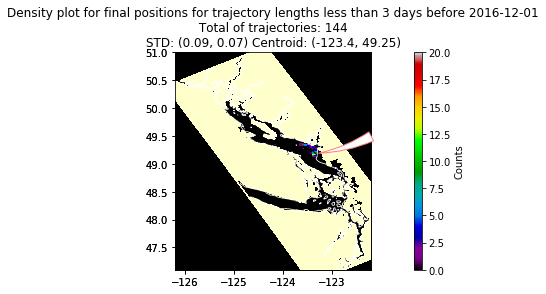

In [9]:
end_date = dt.date(2016, 12,1)
nday = 3

points = lessthan(filesdir, nday = nday, end_date = end_date)


title = (
    "Density plot for final positions for trajectory lengths less than {} days before {}".format(nday, end_date)
)

picname = "/ocean/gsgarbi/MEOPAR/private-docs/reports/IonaProject/ionafigs/{}_{}d_lessthan".format(end_date, nday)

plot (points, title, picname)


plt.show()

2016-11-29 11 2
check
72
2016-11-30 11 1
check
72
start:  2017-06-30 14:09:06.657650


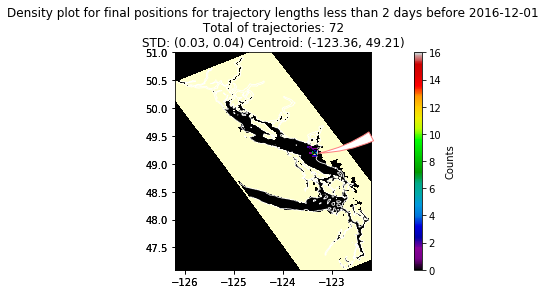

In [10]:
end_date = dt.date(2016, 12,1)
nday = 2

points = lessthan(filesdir, nday = nday, end_date = end_date)


title = (
    "Density plot for final positions for trajectory lengths less than {} days before {}".format(nday, end_date)
)

picname = "/ocean/gsgarbi/MEOPAR/private-docs/reports/IonaProject/ionafigs/{}_{}d_lessthan".format(end_date, nday)

plot (points, title, picname)


plt.show()

In [11]:
end_date = dt.date(2016, 12,1)
nday = 1

points = lessthan(filesdir, nday = nday, end_date = end_date)



title = (
    "Density plot for final positions for trajectory lengths less than {} days before {}".format(nday, end_date)
)

picname = "/ocean/gsgarbi/MEOPAR/private-docs/reports/IonaProject/ionafigs/{}_{}d_lessthan".format(end_date, nday)

plot (points, title, picname)


plt.show()

2016-11-30 11 1
check
0
start:  2017-06-30 14:09:21.237950


IndexError: too many indices for array